## Advaned Lane Finding Pipeline Outline

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").


5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.


7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Libraries

In [1]:
# enable interaction window
%matplotlib qt
%matplotlib inline

# import Python libraries
import os.path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip

# load/save the previous workspace
import pickle

## Helper functions

In [2]:
def plot_images(img1,img2,title1=None,title2=None,save_plot=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1,cmap='gray')
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2,cmap='gray')
    ax2.set_title(title2, fontsize=30)
    
    if save_plot:
        plot_fname = title1 + title2;
        f.savefig(plot_fname)

def show_perspective(img,warped_img,src,dst):
    # Plotting combined threshold images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()

    # Draw polygon to highlight the four source points on the image
    ax1.set_title('Thresholded Image with source points drawn',fontsize=30)
    ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red',linewidth=4)
    ax1.imshow(img, cmap='gray') # display in grayscale
        
    ax2.set_title('Warped result with dest. points drawn',fontsize=30)
    # Draw polygon to highlight the four destination points on the image
    #ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red',linewidth=4)
    ax2.imshow(warped_img, cmap='gray')
    
    # Draw two vertical lines on the image
    ax2.axvline(x=270,color='red',linewidth=4)
    ax2.axvline(x=1040,color='red',linewidth=4)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

###  1. Camera Calibration

Compute the camera calibration matrix and and distortion coefficients given a set of chessboard images

In [3]:
def save_camera_calibration(ret,mtx,dist,rvecs,tvecs):
  
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["ret"] = ret
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    dist_pickle["rvecs"] = rvecs
    dist_pickle["tvec"] = tvecs
    
    # Exclude the object and image points to save to the pickle file
    # dist_pickle["objpoints"] = objpoints
    # dist_pickle["imgpoints"] = imgpoints
            
    # Save the camera calibration pickle file to the "camera_cal" folder
    pickle.dump(dist_pickle, open("camera_cal/camera_cal.p", "wb" ))

def load_camera_calibration(camera_calibration='camera_cal/camera_cal.p'):
    if (os.path.isfile(camera_calibration)):
        dist_pickle = pickle.load( open(camera_calibration, "rb" ) )
        ret = dist_pickle["ret"]
        mtx  = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
        rvecs = dist_pickle["rvecs"]
        tvecs = dist_pickle["tvec"]
    else:
        print('ERROR: Unable to open the camera calibration pickle file')
        return
    return ret, mtx, dist, rvecs, tvecs

def map_obj_img_points(img_name, objpoints, imgpoints, visible=True, h_corners=9, v_corners=6):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (h_corners,v_corners),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if (visible==True):
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (h_corners,v_corners), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)
    else:
        # Notify the user that some images are not valid for camera calibration
        print("Unable to detect corners for image : " + img_name )
    return objpoints, imgpoints
    
def compute_camera_calibration(calibration_images):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane
    
    # Make a list of calibration images
    images = glob.glob(calibration_images)
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        objpoints, imgpoints = map_obj_img_points(fname,objpoints,imgpoints,visible=False)

    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret, mtx, dist, rvecs, tvecs

## Unsuitable images for camera calibrations
 
Noted that the `calibration1.jpg`, `calibration4.jpg`, `calibration5.jpg` pictures are not suitable for camera calibrations as the not all 9x6 corners could be detected.

<table>
    <tr>
        <td> <img src="camera_cal/calibration1.jpg"/> </td>
        <td> <img src="camera_cal/calibration4.jpg"/> </td>
        <td> <img src="camera_cal/calibration5.jpg"/> </td>
    </tr>
    <tr>
        <td> calibration1.jpg <align="middle"/></td>
        <td> calibration4.jpg <align="middle"/></td>
        <td> calibration5.jpg <align="middle"/></td>
    </tr>
</table>

### 2. Distortion Correction

Apply a distortion correction to raw (disorted) images

In [4]:
def undistort_camera_img(img,mtx,dist,show_distortion=False, save_undistort_image=False):   
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)       
    # save undisort image
    if save_undistort_image:
        dist_name = os.path.basename(fname)
        undist_fname = 'output_images/'+ 'undist_' + os.path.splitext(dist_name)[0] + '.jpg'
        cv2.imwrite(undist_fname,undist_img)
    # show distortion comparison
    if show_distortion:
        plot_images(img,undist_img,title1='Camera Image',title2='Undisorted Camera Image')
    return undist_img

ret, mtx, dist, rvecs, tvecs = load_camera_calibration()
images = glob.glob('camera_cal/*.jpg')
for fname in images:
#     print(fname)
    # Read in an image
    img = mpimg.imread(fname)
    undistort_camera_img(img,mtx,dist,show_distortion=False, save_undistort_image=False)

### 3. Threholding binary images
Use color transforms, gradients, etc., to create a thresholded binary image.

`The S channel is still doing a fairly robust job of picking up the lines under very different color and contrast conditions`, while the other selections look messy. You could tweak the thresholds and get closer in the other channels, but the S channel is preferable because it is more robust to changing conditions.

It's worth noting, however, that `the R channel still does rather well on the white lines, perhaps even better than the S channel`. As with gradients, it's worth considering how you might combine various color thresholds to make the most robust identification of the lines.

In [5]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Calculate directional gradient
    # Apply threshold

    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if (orient == 'x'):
        # Take the derivative in x
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif (orient == 'y'):
        # Take the derivative in y
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def saturation_thresh(img,s_thresh):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    return s_binary

def combine_binary_thresh(binary_1,binary_2):
    # Combine binary thresholds (saturation and directional gradient)
    combined_binary = np.zeros_like(binary_1)
    combined_binary[(binary_1 == 1) | (binary_2 == 1)] = 1
    
    return combined_binary

### 4. Perspective Transform

Apply a perspective transform to rectify binary image ("birds-eye view"). Using the two straight lines images to verify that the perspective transform is correct. That is the lane lines in the images aligned with the overlayed vertical lines drawn as shown below.

In [6]:
def warp(img,M):
    img_size = (img.shape[1], img.shape[0])
    # Create warped image using linear interpolation
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_img

### 5. Detect Lane Pixels
Detect lane pixels and fit to find the lane boundary

In [7]:
def get_histogram(img,show_histogram = False):
    
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:] # floor division
    
    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    # along all the columns in the lower half of the image
    # The image data. The returned array has shape (M, N) for grayscale images.
    histogram = np.sum(bottom_half, axis=0)
    
    # Plot the binary image and its histogram 
    if show_histogram:
        histogram = get_histogram(img)       
        fig = plt.figure()
        fig.set_size_inches(8,12)

        ax1 = fig.add_subplot(211)
        ax1.title.set_text('Curve Lanes #6 Binary')
        ax1.imshow(img,cmap='gray')

        ax2 = fig.add_subplot(212)
        ax2.title.set_text('Histogram')
        ax2.plot(histogram)
    return histogram

def fit_polynomial_pixel_space(img_shape,leftx,lefty,rightx,righty):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
    
    return ploty, left_fitx, right_fitx

def detect_lane_lines(img, output_img=False):
    
    show_search_window = True
        
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img)

    if output_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero  = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if output_img:
            #Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    ploty, left_fitx, right_fitx = fit_polynomial_pixel_space(img.shape,leftx,lefty,rightx,righty)
    
    if output_img:
        # Draw left and right pixels in colors
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Draw the line fit for the left and right lane
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))

        if show_search_window:
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            window_img = np.zeros_like(out_img)
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


        return ploty, left_fitx, right_fitx, out_img.astype(int)
    return ploty, left_fitx, right_fitx

### 6. Determine the curvature of the lane and vehicle position with respect to center.


In [8]:
def fit_polynomial_world_space(ploty, leftx, rightx, ym_per_pix, xm_per_pix):
    leftx = leftx[::-1]    # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    try:        
        # Fit polynomials to x,y in world space
        left_fit_cr  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
    
    # Second-order polynomial to predict y position
    # f(y) = Ay^2 + By + Cf(y)
    # Fitting for f(y) rather than f(x) because the lane lines in the warped image 
    # are near vertical and may have the same x value for more than one y value.
    left_A_coeff = left_fit_cr[0]
    left_B_coeff = left_fit_cr[1]
    left_C_coeff = left_fit_cr[2] # not used for prediction
    
    right_A_coeff = right_fit_cr[0]
    right_B_coeff = right_fit_cr[1]
    right_C_coeff = right_fit_cr[2] # not used for prediction
    
    return left_A_coeff, left_B_coeff, right_A_coeff, right_B_coeff

def compute_curvature(img_shape, leftx, rightx, ym_per_pix, xm_per_pix):
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0]) # to cover same y-range as image
    
    # Polynomial line fit in meters (not pixel space any more)
    left_A_coeff, left_B_coeff, right_A_coeff, right_B_coeff = fit_polynomial_world_space(ploty, leftx, rightx, ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # The y values of image creases from top to bottom, so to measure the radius of curvture closest to the vehicle,
    # choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_A_coeff*y_eval + left_B_coeff)**2)**1.5) / np.absolute(2*left_A_coeff)
    right_curverad = ((1 + (2*right_A_coeff*y_eval + right_B_coeff)**2)**1.5) / np.absolute(2*right_A_coeff)
    
    # Estimated lane curvature
    radius_of_curvature = (left_curverad + right_curverad)/2
    
    # The radius of curvature in meters for both lane lines
    return radius_of_curvature, left_curverad, right_curverad

def compute_veh_offset(img_shape, leftx, rightx, xm_per_pix):
    midpointx = img_shape[1]//2
        
    # Vehicle position with respect to the lane
    # Lane center is the midpoint at the bottom of the image between the two lines detected.
    veh_posx = (leftx[-1] + rightx[-1])/2
    
    # Horizontal offset 
    veh_offsetx = (midpointx - veh_posx) * xm_per_pix

    return veh_offsetx

###  7. Warp the Detected Lane Boundary
Warp the detected lane boundaries back onto the original image.

In [9]:
def draw_lane(img,combined_warped,Minv,ploty,left_fitx,right_fitx):
           
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 1, new_warp, 0.3, 0)

    return out_img

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [10]:
def display(img,free_text):

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, free_text, 
                (60, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 5)
    
    return out_img

In [11]:
def display_estimation(img, radius_of_curvature, veh_offsetx):

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Radius of Curvature: {:.0f} (m)'.format(radius_of_curvature), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display vehicle offset
    if veh_offsetx < 0.0: 
        cv2.putText(out_img, 'Vehicle is {:.2f}m left of center'.format(np.absolute(veh_offsetx)), 
                    (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    else:
        cv2.putText(out_img, 'Vehicle is {:.2f}m right of center'.format(veh_offsetx), 
                    (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

## 9. Image Processing

In [15]:
def plot_images_vertical(img1,img2,title1=None,title2=None):
    f, (ax1, ax2) = plt.subplots(2, 1)
    ax1.imshow(img1,cmap='gray')
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2,cmap='gray')
    ax2.set_title(title2, fontsize=30)
    
# Define a class to receive the characteristics of each line detection
class Line:
    # Initalize the class
    def __init__(self, images,always_on_calibrate=True):
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension

        if always_on_calibrate:
            # Calibrate camera
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = compute_camera_calibration(images)
            
            # Optional save the camera calibration as pickle file
            save_camera_calibration(self.ret, self.mtx, self.dist, self.rvecs, self.tvecs)
        else:
            # Load previous camera calibration
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = \
            load_camera_calibration(camera_calibration='camera_cal/camera_cal.p')
        
        # Binary image thresholds
        self.orient = 'x'
        self.sobel_kernel = 3
        self.sx_thresh = [20, 100]
        self.s_thresh = [170, 255]

        # Pick 4 points to transform
        # Note: src and dst points are in [x,y] format
        self.src = np.float32(
        [[245,  680],  # Bottom left
         [580,  460],  # Top left
         [710,  460],  # Top right
         [1060, 680]]) # Bottom right

        self.dst = np.float32(
        [[245,  680],  # Bottom left
         [245,    0],  # Top left
         [1060,   0],  # Top right
         [1060, 680]]) # Bottom right
    
        # The perspective transform matrices
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        
        self.lines_fit = None
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = []
        
        #x values for detected line pixels
        #self.allx = None  
        
        #y values for detected line pixels
        #self.ally = None
        
        self.ploty = None
        self.leftx = None
        self.rightx = None
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
    # This is a special function active during the life time of the execution    
    def __call__(self, img):
        
        # Apply the image processing to the source image
        out_img = self.pipeline(img)
        return out_img
    
    def pipeline(self,img):
        # 1. Calibrate camera (see init method)
        
        # 2. Undistort the image
        undist_img = undistort_camera_img(img,mtx=self.mtx,dist=self.dist)
        out_img = undist_img
        #plot_images(img,undist_img,title1='Camera Image',title2='Undistorted Image')
        
        # 3. Threholding binary images
        # Create gradient-directional threshold binary image
        sx_binary = abs_sobel_thresh(undist_img,self.orient,self.sobel_kernel,self.sx_thresh)
        #plot_images(undist_img,sx_binary,title1='Undisorted Camera Image',title2='Gradient-directional binary')
        
        # Create saturation threshold binary image
        s_binary = saturation_thresh(undist_img,self.s_thresh)
        #plot_images(undist_img,s_binary,title1='Undisorted Camera Image',title2='Saturation binary')
        
        # Stacked binary
        color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary)) * 255
        # Combined binary
        combined_binary = combine_binary_thresh(sx_binary,s_binary)
        #plot_images(color_binary,combined_binary,title1='Stacked binary',title2='Combined binary')
        
        # 4. Perspective Transform
        warped_img = warp(undist_img,self.M)
        #plot_images(undist_img,warped_img,title1=None,title2=None)
        combined_warped = warp(combined_binary,self.M)
        #plot_images(warped_img,combined_warped,title1='Bird-eye view',title2='Bird-eye view binary')
        
        # 5. Detect lane lines
        self.ploty, self.leftx, self.rightx = detect_lane_lines(combined_warped)
        # Disable the output image for the detect_lane_lines to save computation
        #self.ploty, self.leftx, self.rightx, out_img = detect_lane_lines(combined_warped, output_img=True)
        
        # 6a. Calculate lane curvature
        self.radius_of_curvature, self.left_curvature, self.right_curvature = \
            compute_curvature(combined_warped.shape, self.leftx, self.rightx,\
                                          self.ym_per_pix, self.xm_per_pix)

        # 6b. Calculate the vehicle offset relative to the lane center
        self.line_base_pos = compute_veh_offset(img.shape, self.leftx, self.rightx, self.xm_per_pix)
        
        # 7. Draw lane lines on the image
        lane_img = draw_lane(img,combined_warped,self.Minv,self.ploty,self.leftx,self.rightx)
        out_img = lane_img
              
        # 8. Display the lane curvature and vehicle offset (to the lane)
        out_img = display_estimation(lane_img, self.radius_of_curvature, self.line_base_pos)
        
        # Free text overlay the image
        out_img = display(out_img,'')
        
        return out_img

# Image Processing

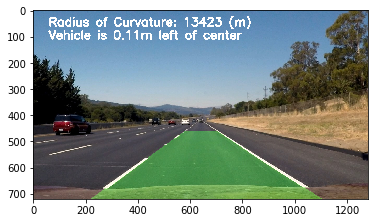

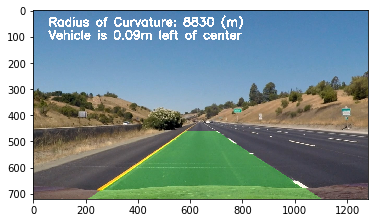

In [16]:
enable_manual_image_processing = True

if enable_manual_image_processing:
    # Specify the location of camera calibration
    camera_cal_imgs = 'camera_cal/calibration*.jpg'

    # Specify the location of the test images
    test_imgs='test_images/*lines*.jpg'

    # Create a list of images
    images = glob.glob(test_imgs)
    for fname in images:
        # Read in an image
        img = mpimg.imread(fname)
        
        # Initalize the image processing pipeline
        process_image = Line(camera_cal_imgs,always_on_calibrate=False)
        
        # Run the image processing pipeline
        out_img = process_image.pipeline(img)
        plt.figure()
        plt.imshow(out_img)

        write_output_image = False
        if write_output_image:
            output_image = 'output_images/' + os.path.basename(fname)
            out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_image,out_img)

## Video Processing

In [ ]:
enable_video_processing = False

if enable_video_processing:
    input_video = 'test_videos/project_video.mp4'
    output_video = 'output_videos/output_project_video.mp4'

    preprocess_clip = VideoFileClip(input_video)
    #preprocess_clip = VideoFileClip(input_video).subclip(0,5.0) #or subclip with the first 5 seconds

    # Process video frames with our 'process_image' function
    camera_cal_imgs = 'camera_cal/calibration*.jpg'
    process_image = Line(camera_cal_imgs)

    postprocess_clip = preprocess_clip.fl_image(process_image)

    %time postprocess_clip.write_videofile(output_video, audio=False)